In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV 
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

In [35]:
df = pd.read_csv("Data/Residential-Building-Data-Set.csv", header = 1)

In [36]:
df.head()

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,...,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,1010.84,...,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200.0,410.0
1,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,963.81,...,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000.0,1000.0
2,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,689.84,...,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200.0,170.0
3,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,459.54,...,152.25,1442.31,1456.0,9.73,8.34,686.16,8194.0,122031.7,165.0,30.0
4,87.0,1.0,90.0,2.0,1.0,3000.0,800.0,1230.0,410.0,631.91,...,2244.10,9231.76,9286.0,136.60,140.20,9821.00,48260.0,1734973.5,5500.0,700.0


In [37]:
print(df.shape)
print(df.describe())

(372, 109)
       START YEAR  START QUARTER  COMPLETION YEAR  COMPLETION QUARTER  \
count  372.000000     372.000000       372.000000          372.000000   
mean    81.483871       2.190860        82.951613            2.586022   
std      4.182141       1.083382         4.223898            1.123442   
min     72.000000       1.000000        73.000000            1.000000   
25%     78.000000       1.000000        80.000000            2.000000   
50%     82.000000       2.000000        84.000000            3.000000   
75%     85.000000       3.000000        87.000000            4.000000   
max     88.000000       4.000000        90.000000            4.000000   

              V-1           V-2          V-3          V-4         V-5  \
count  372.000000    372.000000   372.000000   372.000000  372.000000   
mean     9.728495   1729.044355   426.114247   327.904086  163.118280   
std      6.563309   1802.371491   490.076498   563.544337  112.604343   
min      1.000000    200.000000    60.0

- Split Data into X and y subsets. X being the entire data frame without V-9 and V-10 and y being the target column of V-10. 
- We removed V-9 because it is the final sales price which can leak data about V-10 which violates our ML golden rule

In [38]:
X = df.drop(columns = ['V-9', 'V-10'])
y = df['V-10']

Split data into #80 , #20 Training, testing split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state = 42)

Performing Exploratory Data Analysis

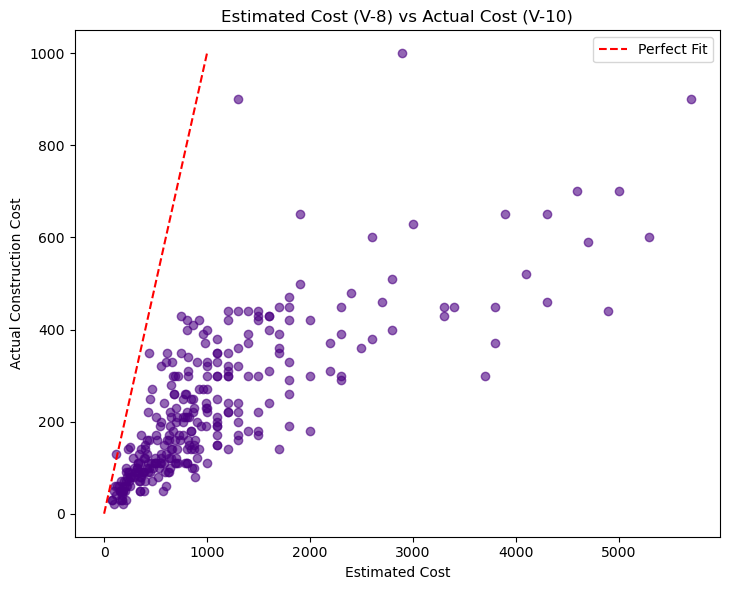

In [44]:
plt.figure(figsize=(14, 6))

#Histogram of Distribution of Construction Costs (V-10)
plt.subplot(1, 2, 2)
plt.scatter(X_train['V-8'], y_train, alpha=0.6, color='indigo')
plt.plot([0, y_train.max()], [0, y_train.max()], 'r--', label='Perfect Fit')
plt.title("Estimated Cost (V-8) vs Actual Cost (V-10)")
plt.xlabel("Estimated Cost")
plt.ylabel("Actual Construction Cost")
plt.legend()

plt.tight_layout()
plt.show()